### **1. Libraries** <a class="anchor" id="1"></a>

In [1]:
# date manipulation
from datetime import datetime

# data manipulation
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt

# supervised discretization
from optbinning import OptimalBinning

# preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# models
from xgboost import XGBClassifier

# model selection
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split

# model metrics
from sklearn.metrics import roc_curve, f1_score

# warnings
import warnings
warnings.filterwarnings('ignore')

(CVXPY) Jun 06 02:14:49 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 06 02:14:49 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


### **2. Functions** 

Later on, the reason and the intuition behind the function standardize_salary_per_hour will be explained for better understanding. After the explanation, I recommend going back to this code snippet to look at the function in more depth.

In [2]:
def standardize_salary_per_hour(dataset_row):
    denominator_weight = 1
    
    if dataset_row['unidade_de_salario'] == 'Hora':
        return dataset_row['salario_prevalecente']

    # denominator_weight will decrease the value of the denominator if the job position is part-time
    if dataset_row['posicao_em_tempo_integral'] == 'N':
        denominator_weight = 0.5

    # horas úteis de trabalho em cada unidade de tempo
    if dataset_row['unidade_de_salario'] == 'Semana':
        denominator = 40
    elif dataset_row['unidade_de_salario'] == 'Mês':
        denominator = 172
    elif dataset_row['unidade_de_salario'] == 'Ano':
        denominator = 2064
    
    return round(dataset_row['salario_prevalecente'] / (denominator * denominator_weight), 2)

<a id="3"></a>
### **3. Importando dados**

In [3]:
train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [4]:
train.head()

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,69711.24,Ano,S,Negado
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,52931.38,Ano,S,Aprovado
2,EZYV5207,Ásia,Ensino Médio,N,N,1426,2000,Ilha,110830.21,Ano,S,Negado
3,EZYV7545,Ásia,Ensino Médio,N,N,3846,1992,Meio-Oeste,91884.68,Semana,S,Negado
4,EZYV16071,Ásia,Ensino Superior,S,N,3957,1949,Nordeste,138155.24,Ano,S,Aprovado


<a id="4"></a>
### **4. EDA**

<a id="4.1"></a>
**4.1. Shape**

In [5]:
train.shape

(17836, 12)

<a id="4.2"></a>
**4.2. General Data Information**

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17836 entries, 0 to 17835
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id_do_caso                      17836 non-null  object 
 1   continente                      17836 non-null  object 
 2   educacao_do_empregado           17836 non-null  object 
 3   tem_experiencia_de_trabalho     17836 non-null  object 
 4   requer_treinamento_de_trabalho  17836 non-null  object 
 5   num_de_empregados               17836 non-null  int64  
 6   ano_de_estabelecimento          17836 non-null  int64  
 7   regiao_de_emprego               17836 non-null  object 
 8   salario_prevalecente            17836 non-null  float64
 9   unidade_de_salario              17836 non-null  object 
 10  posicao_em_tempo_integral       17836 non-null  object 
 11  status_do_caso                  17836 non-null  object 
dtypes: float64(1), int64(2), object(

<a id="4.3"></a>
**4.3. Target Variable Balancing**

In [7]:
train['status_do_caso'].value_counts(normalize=True)

status_do_caso
Aprovado    0.669264
Negado      0.330736
Name: proportion, dtype: float64

<a id="4.4"></a>
**4.4. Statistical Summary**

In [8]:
categorical_cols = (
    train
    .select_dtypes(include='O')
    .drop('id_do_caso', axis=1)
    .keys()
)

In [9]:
train.describe()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente
count,17836.00000,17836.000000,17836.000000
mean,5726.50185,1979.494898,74327.428401
std,23321.37739,42.097194,52795.859573
min,-26.00000,1800.000000,2.136700
25%,1023.00000,1976.000000,33892.912500
50%,2117.00000,1997.000000,70106.920000
75%,3504.25000,2005.000000,107564.715000
max,602069.00000,2016.000000,319210.270000


In [10]:
X_test.describe()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente
count,7644.000000,7644.000000,7644.000000
mean,5528.306384,1979.211669,74755.382371
std,21809.034818,42.991855,52865.015248
min,-26.000000,1800.000000,3.003100
25%,1020.000000,1976.000000,34178.027500
50%,2094.500000,1997.000000,70716.775000
75%,3501.000000,2005.000000,108106.945000
max,547172.000000,2016.000000,306206.670000


The data follow similar distributions in both datasets. Here are some considerations:

- **num_de_empregados:** Variable has negative values, a very high standard deviation and a very high maximum value, indicating a distribution with a very long tail to the right;

- **salario_prevalecente:** This column indicates the salary earned per unit of time. The time information is contained in the column unit_de_salario, which has the units: Hour, Week, Month and Year. Therefore, it is still not possible to analyze the distribution correctly because the wage/hour rate is not standardized. Even so, it appears that the variable has a very high standard deviation and a very high maximum value, indicating a distribution with a very long tail to the right;

- **year_of_establishment:** The establishment of companies ranges from the years 1800 to 2016, half of which were incorporated before 1997. The standard deviation is 42 years;

Total negative values ​​for column num_de_empregados in both datasets.

In [11]:
len(train[train['num_de_empregados'] <= 0]) + len(X_test[X_test['num_de_empregados'] <= 0])

33

In [12]:
train[categorical_cols].describe()

,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,regiao_de_emprego,unidade_de_salario,posicao_em_tempo_integral,status_do_caso
count,17836,17836,17836,17836,17836,17836,17836,17836
unique,6,4,2,2,5,4,2,2
top,Ásia,Ensino Superior,S,N,Nordeste,Ano,S,Aprovado
freq,11765,7151,10380,15755,5064,16089,15934,11937


In [13]:
X_test[categorical_cols[:-1]].describe()

,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,regiao_de_emprego,unidade_de_salario,posicao_em_tempo_integral
count,7644,7644,7644,7644,7644,7644,7644
unique,6,4,2,2,5,4,2
top,Ásia,Ensino Superior,S,N,Nordeste,Ano,S
freq,5096,3083,4422,6770,2131,6873,6839


<a id="4.5"></a>
**4.5. Data Visualization**

<a id="4.5.1"></a>
**4.5.1. Categorical Variables**

The plots are very objective, seeking to identify how the different classes within each category influence the target variable and tend to be good predictor variables.

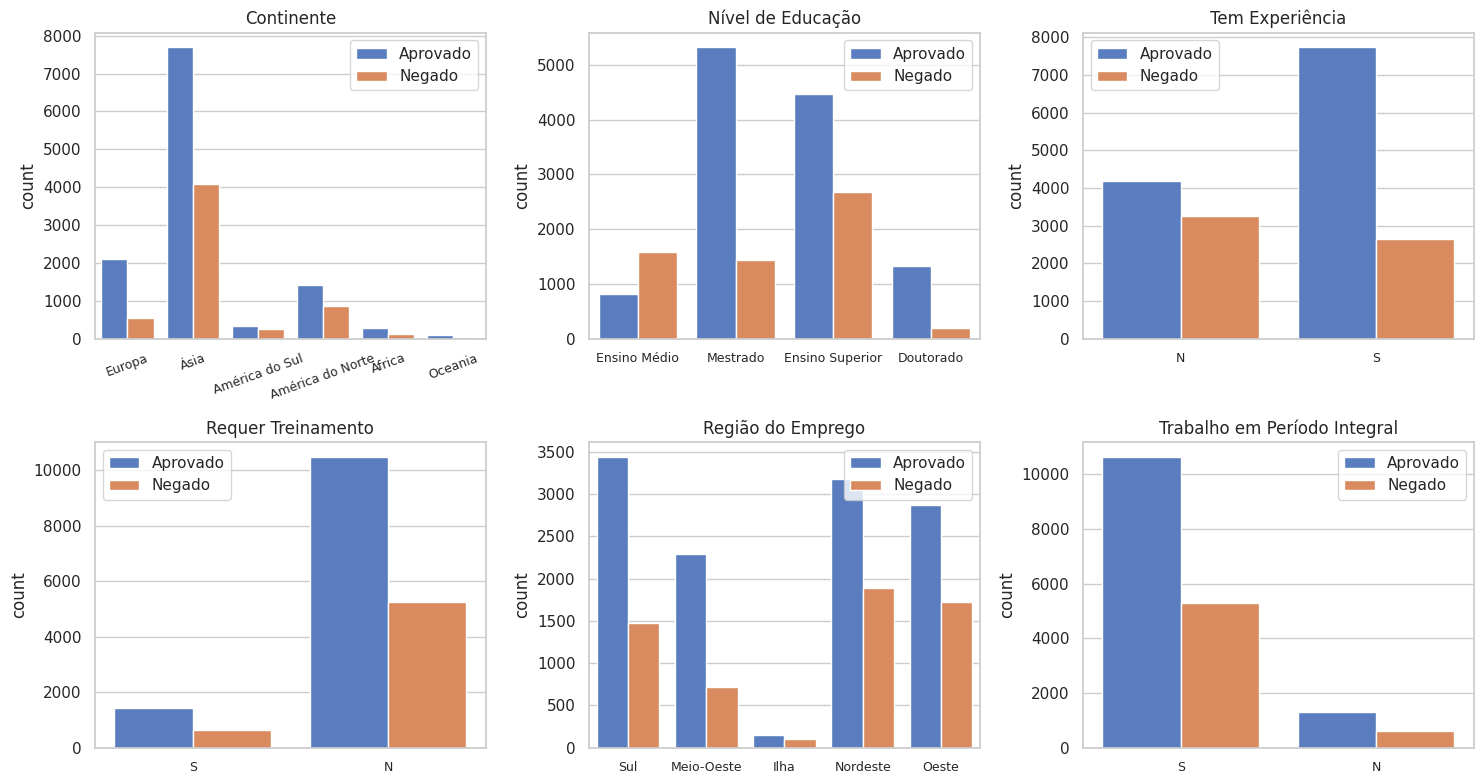

In [15]:
categorical_cols = categorical_cols.delete([5, 7]) # Remove features that I will not use in the plot, salary_unit and case_status
categorical_titles = ['Continente', 'Nível de Educação', 'Tem Experiência', 'Requer Treinamento', 'Região do Emprego', 'Trabalho em Período Integral']

fig, ((ax1, ax2, ax3), ( ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(categorical_cols)):
    ax = axes[i]
    sns.countplot(data=train, x=categorical_cols[i], hue='status_do_caso', palette='muted', ax=ax, hue_order=['Aprovado', 'Negado'])
    ax.set_title(categorical_titles[i])
    ax.set_xlabel('')
    _, labels = ax.get_legend_handles_labels()
    ax.legend(labels=labels[:])
    if categorical_titles[i] == 'Continente':
        ax.tick_params(axis='x', rotation=20, labelsize=9)
    else:
        ax.tick_params(axis='x', labelsize=9)

fig.tight_layout()

plt.show()

Through the analysis of the plots, it can be seen that the variables **educacao_do_empregado** and **tem_experiencia_de_work** have greater potential as predictors, since the variation of the class has an impact on the number of passers and failers.

<a id="4.5.2"></a>
**4.5.2. Numerical Variables**

A value window was selected for the plot of column num_de_empregados because the distribution has a very elongated tail on the right, which makes it impossible to visualize the distribution. It was also decided to leave the visualization of the columnar salario_prevalecente for a moment after its standardization.

In [16]:
num_empregados_plot = (
    train
    .query('num_de_empregados < 8000')
    .get('num_de_empregados')
)

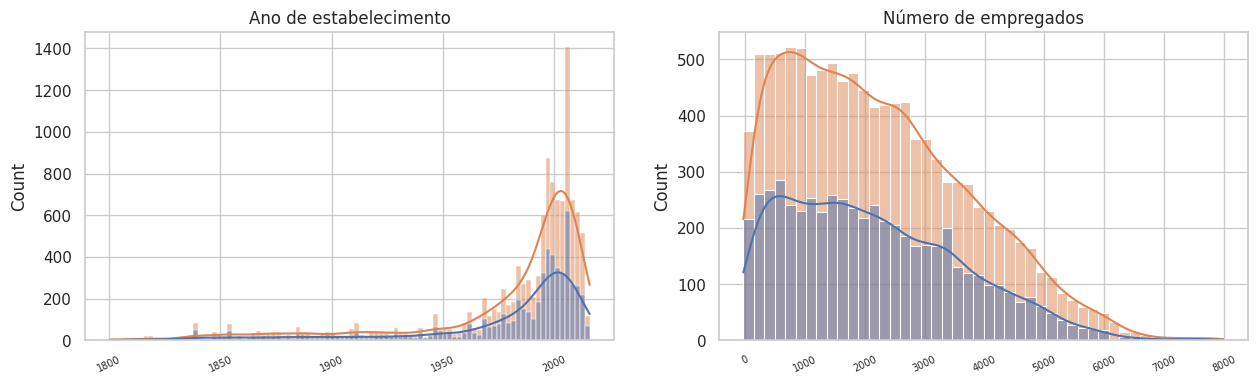

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(data=train, x='ano_de_estabelecimento', hue='status_do_caso', ax=ax1, kde=True, legend=False)
ax1.set_title('Ano de estabelecimento')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=25, labelsize=7)

sns.histplot(data=train, x=num_empregados_plot, hue='status_do_caso', ax=ax2, kde=True, legend=False)
ax2.set_title('Número de empregados')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=25, labelsize=7)

<a id="5"></a>
### **5. Feature Engeneering**

<a id="5.1"></a>
**5.1. Fit for Work**

This column is the union of the information coming from the columns **require_training_of_work** and **have_experience_of_work**. It was considered that the candidate who already has experience and does not need training is fit.

In [18]:
train['apto_ao_trabalho'] = (
    train['requer_treinamento_de_trabalho'] +
    '_' +
    train['tem_experiencia_de_trabalho']
)

X_test['apto_ao_trabalho'] = (
    X_test['requer_treinamento_de_trabalho'] + 
    '_' +
    X_test['tem_experiencia_de_trabalho']
)

train['apto_ao_trabalho'] = train['apto_ao_trabalho'].replace(['N_N', 'N_S', 'S_N', 'S_S'], [0, 0, 0, 1])
X_test['apto_ao_trabalho'] = X_test['apto_ao_trabalho'].replace(['N_N', 'N_S', 'S_N', 'S_S'], [0, 0, 0, 1])

train = train.drop(['requer_treinamento_de_trabalho'], axis=1)
X_test = X_test.drop(['requer_treinamento_de_trabalho'], axis=1)

<a id="5.2"></a>
**5.2. Company Age**

In [19]:
ano_atual = datetime.now().year

train['tempo_empresa'] = ano_atual - train['ano_de_estabelecimento']
X_test['tempo_empresa'] = ano_atual - X_test['ano_de_estabelecimento']

train = train.drop(['ano_de_estabelecimento'], axis=1)
X_test = X_test.drop(['ano_de_estabelecimento'], axis=1)

<a id="5.3"></a>
**5.3. Case Status**

The transformation of the target column **status_do_case** was carried out at this point for the correct functioning of the **OptimalBinning** class that is used in the next topics.

In [20]:
train['status_do_caso'] = train['status_do_caso'].replace(['Negado', 'Aprovado'], [0, 1])

<a id="5.4"></a>
**5.4. Number of Discretized Employees**

**Supervised Discretization**

In [21]:
optb = OptimalBinning(name='num_de_empregados' , dtype='numerical', solver='mip')
optb.fit(train['num_de_empregados'], train['status_do_caso'])
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3130.50)",12360,0.692980,4146,8214,0.664563,0.021164,0.000311,0.000039
1,"[3130.50, 3481.50)",962,0.053936,368,594,0.617464,0.226064,0.002853,0.000356
2,"[3481.50, 4415.50)",1881,0.105461,592,1289,0.685274,-0.073255,0.000559,0.000070
3,"[4415.50, inf)",2633,0.147623,793,1840,0.698823,-0.136838,0.002697,0.000337
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,17836,1.000000,5899,11937,0.669264,,0.006421,0.000802


- **Bin:** the intervals delimited by the optimal split points;

- **Count:** the number of records for each bin;

- **Count (%):** the percentage of records for each bin;

- **Non-event:** the number of non-event records (y=0)

for each bin;

- **Event:** the number of event records (y=1)

for each bin;

- **Event rate:** the percentage of event records for each bin;

- **WoE:** the Weight-of-Evidence for each bin;

- **IV:** the Information Value (also known as Jeffrey’s divergence) for each bin;

- **JS:** the Jensen-Shannon divergence for each bin;

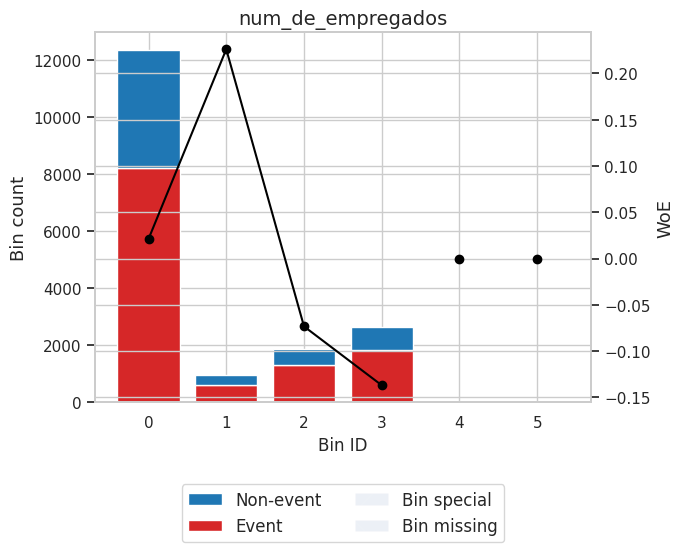

In [22]:
binning_table.plot(metric='woe')

In [23]:
min = train['num_de_empregados'].min()
max = train['num_de_empregados'].max()
bins = np.concatenate(([min-1], optb.splits, [max+1]))

In [24]:
train['num_de_empregados_cut'] = pd.cut(train['num_de_empregados'], 
                                        bins = bins, 
                                        labels = list(range(1, len(bins))))

X_test['num_de_empregados_cut'] = pd.cut(X_test['num_de_empregados'], 
                                        bins, 
                                        labels = list(range(1, len(bins))))

train = train.drop(['num_de_empregados'], axis=1)
X_test = X_test.drop(['num_de_empregados'], axis=1)

train['num_de_empregados_cut'] = train['num_de_empregados_cut'].astype(int)
X_test['num_de_empregados_cut'] = X_test['num_de_empregados_cut'].astype(int)

<a id="5.5"></a>
**5.5. Prevailing Salary Discretized Hour**

As previously mentioned, salary/time information is divided into three distinct columns: **prevailing_salary**, **salary_unit** and **full-time_position**. Therefore, in the first column we have the numerical information of the salary, in the second the unit of time in which this salary is received and in the last the factor that says whether the position is full-time, which directly affects the number of working hours in certain time. The different classes for each column generate a lack of standardization of salary/time information, which can be, for example, salary/hour, salary/week, and this makes it difficult to analyze the information. Machine learning algorithms are able to learn the relationships between variables, but in order to improve the model result, it was decided to centralize the information.

Example: a week has 40 working hours, if it is a part-time job this value drops to 20 hours. Assuming that the prevailing wage is 500 and the wage unit per week we will have a wage of 500/week. Therefore, the candidate is earning 12.5/hour worked if full-time and 25/hour if part-time.

In [25]:
train['salario_prevalecente_hora'] = train.apply(standardize_salary_per_hour, axis=1)
X_test['salario_prevalecente_hora'] = X_test.apply(standardize_salary_per_hour, axis=1)
train = train.drop(['salario_prevalecente'], axis=1)
X_test = X_test.drop(['salario_prevalecente'], axis=1)

**Discretização Supervisionada** 

In [26]:
optb = OptimalBinning(name='salario_prevalecente_hora' , dtype='numerical', solver='mip')
optb.fit(train['salario_prevalecente_hora'], train['status_do_caso'])
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 10.55)",1676,0.093967,420,1256,0.749403,-0.390573,0.013288,0.001650
1,"[10.55, 16.12)",1118,0.062682,335,783,0.700358,-0.144142,0.001269,0.000159
2,"[16.12, 42.75)",6310,0.353779,1899,4411,0.699049,-0.137914,0.006565,0.000820
3,"[42.75, 52.81)",2055,0.115216,634,1421,0.691484,-0.102207,0.001182,0.000148
4,"[52.81, 76.32)",2954,0.165620,950,2004,0.678402,-0.041579,0.000284,0.000036
5,"[76.32, 100.21)",892,0.050011,308,584,0.654709,0.065059,0.000214,0.000027
6,"[100.21, 151.04)",1222,0.068513,451,771,0.630933,0.168639,0.002001,0.000250
7,"[151.04, inf)",1609,0.090211,902,707,0.439403,0.948444,0.088850,0.010708
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


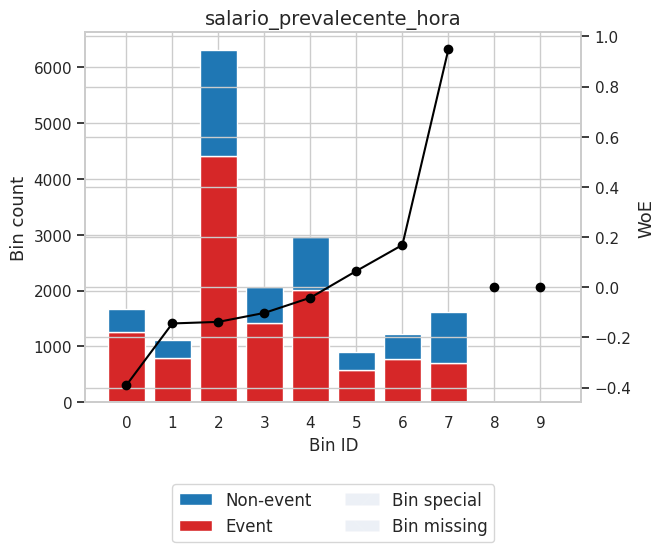

In [27]:
binning_table.plot(metric='woe')

In [28]:
min = train['salario_prevalecente_hora'].min()
max = train['salario_prevalecente_hora'].max()
bins = np.concatenate(([min-1], optb.splits, [max+1]))

In [29]:

train[f'salario_prevalecente_hora_cut'] = pd.cut(train['salario_prevalecente_hora'], 
                                        bins = bins, 
                                        labels = list(range(1, len(bins)))
                                        )

X_test[f'salario_prevalecente_hora_cut'] = pd.cut(X_test['salario_prevalecente_hora'], 
                                        bins, 
                                        labels = list(range(1, len(bins)))
                                        )

train = train.drop(['salario_prevalecente_hora'], axis=1)
X_test = X_test.drop(['salario_prevalecente_hora'], axis=1)

train['salario_prevalecente_hora_cut'] = train['salario_prevalecente_hora_cut'].astype(int)
X_test['salario_prevalecente_hora_cut'] = X_test['salario_prevalecente_hora_cut'].astype(int)

<a id="6"></a>
### **6. Pré-processamento**

In [30]:
nominal_cols = ['continente', 'regiao_de_emprego']

ordinal_cols = [
    'tem_experiencia_de_trabalho', 
    'posicao_em_tempo_integral',
    'educacao_do_empregado',
    'unidade_de_salario',
]

In [31]:
ordinal_encoder = OrdinalEncoder(categories=[
    ['N', 'S'], # tem_experiencia_de_trabalho
    ['N', 'S'], # posicao_em_tempo_integral
    ['Ensino Médio', 'Ensino Superior', 'Mestrado', 'Doutorado'], # educacao_do_empregado
    ['Hora', 'Semana', 'Mês', 'Ano'] # unidade_de_salario
])

train[ordinal_cols] = ordinal_encoder.fit_transform(train[ordinal_cols])
X_test[ordinal_cols] = ordinal_encoder.transform(X_test[ordinal_cols])

In [32]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train[nominal_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[nominal_cols]))

OH_cols_train.index = train.index
OH_cols_test.index = X_test.index

X_train = train.drop(nominal_cols, axis=1)
X_test = X_test.drop(nominal_cols, axis=1)

OH_X_train = pd.concat([X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([X_test, OH_cols_test], axis=1)

OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

<a id="7"></a>
### **7. Train**

<a id="7.1"></a>
**7.1. Splitting matrix of features and vector with target variable** 

In [33]:
y_train = OH_X_train['status_do_caso'].values.ravel()
OH_X_train = OH_X_train.drop(['status_do_caso', 'id_do_caso'], axis=1)

<a id="7.2"></a>
**7.2. Splitting test data**

In [34]:
# Format for submission
test_ids = pd.DataFrame(OH_X_test['id_do_caso'])
# Remove id
OH_X_test = OH_X_test.drop(['id_do_caso'], axis=1)

<a id="7.3"></a>
**7.3. Hyperparameter Optimization**

In [35]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
scale_pos_weight = np.unique(y_train, return_counts=True)[1][0] / np.unique(y_train, return_counts=True)[1][1]

In [37]:
xgb_classifier = XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=142)

param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 3000, num = 20)],
    'max_depth': [int(x) for x in np.linspace(1, 10, num = 10)],
    'gamma': [i/10.0 for i in range(0,5)],
    'subsample':[float(x) for x in np.linspace(0.5, 1, num = 5)],
    'colsample_bytree' : [i/10.0 for i in range(5,11)],
    'min_child_weight' : [i for i in range(1,11)],
    'learning_rate': [float(x) for x in np.linspace(1e-3, 1e-1, num = 15)]
}  

rsearch = RandomizedSearchCV(
    xgb_classifier,
    param_distributions = param_dist,
    scoring='roc_auc',
    cv=kf, 
    verbose=False
)

rsearch.fit(OH_X_train, y_train)

print(rsearch.best_estimator_)
print(rsearch.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.015142857142857142,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=142, ...)
{'subsample': 0.625, 'n_estimators': 200, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.015142857142857142, 'gamma': 0.1, 'colsample_bytree': 0.9}


<a id="7.4"></a>
**7.4. Desempenho do Modelo - Cross Validation**

In [38]:
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    n_estimators=1231,
    learning_rate=0.001,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    max_depth=8,
    min_child_weight=1,
    subsample=1.0,
    random_state=42,
    n_jobs=-1,
    gamma=0.02,
)

scores = cross_val_score(
    xgb_classifier, 
    OH_X_train, 
    y_train,
    cv=kf,
    scoring='roc_auc'
)

print(f"ROC_AUC scores: {scores}\nmédia: {scores.sum() / len(scores)}")

ROC_AUC scores: [0.77651233 0.78705488 0.79893313 0.77453385 0.76657087]
média: 0.7807210123385786


<a id="8"></a>
### **8. Predictions**

<a id="8.1"></a>
**8.1. Decision Threshold**

In [39]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(OH_X_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

xgb_classifier.fit(Xtrain, ytrain)
ypred = xgb_classifier.predict_proba(Xvalid)[:,1]

fpr, tpr, thresholds = roc_curve(yvalid, ypred)
f1_score_ls = []
for thres in thresholds:
    y_pred = np.where(ypred>thres,1,0)
    f1_score_ls.append(f1_score(yvalid, y_pred, average="weighted"))
    
f1_score_ls = pd.concat([pd.Series(thresholds), pd.Series(f1_score_ls)],
                        axis=1)
f1_score_ls.columns = ['thresholds', 'f1_score']
f1_score_ls.sort_values(by='f1_score', ascending=False, inplace=True)
f1_score_ls.head()

,thresholds,f1_score
1384,0.446371,0.736176
1385,0.445796,0.736130
1386,0.445595,0.736083
1382,0.446609,0.736057
1388,0.445097,0.736035


<a id="8.2"></a>
**8.2. Predictions**

Five models with different seeds are trained to perform an ensemble of predictions by averaging the scores.

In [40]:
p = np.zeros((OH_X_test.shape[0], 5))
for seed in range(5):
    xgb_classifier = XGBClassifier(
        objective='binary:logistic',
        n_estimators=820,
        learning_rate=0.01,
        colsample_bytree=0.6,
        scale_pos_weight=scale_pos_weight,
        max_depth=4,
        min_child_weight=6,
        subsample=0.625,
        random_state=seed,
        n_jobs=-1,
        gamma=0.01,
    )
    xgb_classifier.fit(OH_X_train, y_train)
    p[:, seed] = xgb_classifier.predict_proba(OH_X_test)[:, 1]

<a id="9"></a>
### **9. Submission**

In [41]:
threshold = 0.446371
test_ids['status_do_caso'] = p.mean(axis=1)
test_ids['status_do_caso'] = test_ids['status_do_caso'].map(lambda x: 1 if x > threshold else 0)
test_ids.to_csv('sub.csv', index=False)